In [339]:
import pandas as pd
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
import surprise
from surprise import SVD, SVDpp, NMF
from surprise import Dataset
from surprise import Reader
from surprise import evaluate, print_perf
from surprise import KNNBasic
from surprise import AlgoBase, BaselineOnly
from get_top_n import get_top_n
from surprise.accuracy import rmse, mae

# Model based

In [340]:
#Load data
dt = pd.read_csv('sample_data.csv',index_col=0)
dt.head()

reviewerID   productID  rating        date
370183  A2OR4QUQSUMOW7  B0016B9FSU     4.0  2013-01-31
370186  A14E7LZASLSX36  B0016B9FSU     5.0  2013-03-21
370189   A9ESHA5MS6S6L  B0016B9FSU     5.0  2013-01-17
370192   ATATZGNDHA5ZD  B0016B9FSU     5.0  2013-02-05
370193   AN4HRAGRHHX1H  B0016B9FSU     5.0  2013-01-03

In [341]:
#Construct missing ratings we need to predict
select_data = dt.pivot_table('rating',index=['reviewerID','productID'],dropna=False)
select_data = select_data.loc[select_data['rating'].isnull()]
select_data.reset_index(inplace=True)
missing_values = select_data[['reviewerID','productID']].values

In [342]:
reader = Reader(rating_scale=(1,5))
dt = Dataset.load_from_df(dt[['reviewerID','productID','rating']],reader)

In [343]:
raw_ratings = dt.raw_ratings
#Shuffle ratings
random.seed(42)
random.shuffle(raw_ratings)
#Split to training and test sets
threshold = int(.8 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

In [344]:
dt.raw_ratings = A_raw_ratings  # dt is now the set A - training set
dt.split(n_folds=3)

In [345]:
#Baseline model: User's bias & item's bias
class BaselineModel(AlgoBase):

    def __init__(self):
        AlgoBase.__init__(self)

    def compute_bias(self):
        bu = np.zeros(self.trainset.n_users)
        bi = np.zeros(self.trainset.n_items)
        global_mean = self.trainset.global_mean
        
        for i in self.trainset.all_items():
            dev_i = 0
            for (u, r) in self.trainset.ir[i]:
                dev_i += r - global_mean
            bi[i] = dev_i/(len(self.trainset.ir[i]))
        
        for u in self.trainset.all_users():
            dev_u = 0
            for (i, r) in self.trainset.ur[u]:
                dev_u += r - global_mean
            bu[u] = dev_u/(len(self.trainset.ur[u]))
        return bu, bi
    
    def train(self, trainset):
        AlgoBase.train(self, trainset)
        self.bu, self.bi = self.compute_bias()

    def estimate(self, u, i):
        est = self.trainset.global_mean
        if self.trainset.knows_user(u):
            est += self.bu[u]
        if self.trainset.knows_item(i):
            est += self.bi[i]
        return est

algo1 = BaselineModel()

In [346]:
#Construct train set and test set for use by surprise
trainset = dt.build_full_trainset()
testset = dt.construct_testset(B_raw_ratings)  # testset is now the set B

In [347]:
#Train and predict using baseline model
algo1.train(trainset)
baseline_predictions = algo1.test(testset)

In [348]:
#Accuracy on test set
rmse(baseline_predictions)
mae(baseline_predictions)

RMSE: 1.0607
MAE:  0.7961


0.79607315037876514

In [349]:
#SVD
algo2 = SVD()
algo2.train(trainset)
svd_predictions = algo2.test(testset)
rmse(svd_predictions)
mae(svd_predictions)

RMSE: 0.9572
MAE:  0.7484


0.74837625011915421

# Metrics

In [350]:
#Function to calculate coverage ratio
def coverage_ratio(predictions, n):
    top_n = get_top_n(predictions, n)
    product_list = []
    recommended_list = []
    for uid, iid, true_r, est, _ in predictions:
        product_list.append(iid)
    for uid, user_ratings in top_n.items():
        recommended_list.append(user_ratings[0][0])
    coverage = float(len(set(recommended_list))) / float(len(set(product_list)))
    return coverage

In [351]:
coverage_ratio(svd_predictions,1)

0.9428571428571428

In [352]:
#Function to predict missing values based on an algorithm
def mv_prediction(algo,missing_values):
    predictions = [algo.predict(uid, iid)
                       for (uid, iid) in missing_values]
    return predictions

In [353]:
mv_prediction_list = mv_prediction(algo2,missing_values)

In [354]:
coverage_ratio(mv_prediction_list,7)

0.22857142857142856

# KNN

## use a default knn config

In [355]:
## define algorithm config
algo_name = KNNBasic ##  KNNWithMeans,KNNBaseline
sim_option={'name': 'cosine', ## cosine, msd, pearson, personbaseline
                 'user_based': 'False', ## False for item-based
                 'min_surpport':0 }##  if |Iuv|<min_support then sim(u,v)=0
max_k = 40 ## The (max) number of neighbors to take into account for aggregation
min_k = 1 ##  If there are not enough neighbors, the prediction is set the the global mean of all ratings

In [356]:
knn_default = algo_name(k = max_k, min_k = min_k, sim_options=sim_option)

In [357]:
knn_default.train(trainset)
defaultknn_prediction=knn_default.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


### accuracy

In [358]:
# the accuracy of the tainset
perf = evaluate(knn_default, dt, measures=['RMSE','MAE'], verbose= 1)

Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9879
MAE:  0.7674
------------
Fold 2
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0019
MAE:  0.7671
------------
Fold 3
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9812
MAE:  0.7733
------------
------------
Mean RMSE: 0.9904
Mean MAE : 0.7693
------------
------------


In [359]:
#Accuracy on test set
rmse(defaultknn_prediction)
mae(defaultknn_prediction)

RMSE: 0.9995
MAE:  0.7768


0.77677919770828352

### coverage

In [360]:
coverage_ratio(defaultknn_prediction,1)

0.9571428571428572

In [361]:
mv_knnprediction = mv_prediction(knn_default,missing_values)
coverage_ratio(mv_knnprediction,7)

0.2857142857142857

## changing hyper-paramater

In [362]:
algo_name = KNNBasic
#Define the different hyper-paramter range
grid_param = {'k':[20,30,40,50,60],
             'min_k':[1,5,10],
             'sim_options':{'name':['msd','cosine','pearson'],
                           'min_surpport':[0,3,5],
                           'user_based':[False]}
             }

In [363]:
grid_search = surprise.GridSearch(algo_name, grid_param, measures=['RMSE', 'MAE'],verbose = 1)
grid_search.evaluate(dt)

[{'k': 20, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 0, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 3, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 5, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'cosine', 'min_surpport': 0, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'cosine', 'min_surpport': 3, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'cosine', 'min_surpport': 5, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'pearson', 'min_surpport': 0, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'pearson', 'min_surpport': 3, 'user_based': False}}, {'k': 20, 'min_k': 1, 'sim_options': {'name': 'pearson', 'min_surpport': 5, 'user_based': False}}, {'k': 20, 'min_k': 5, 'sim_options': {'name': 'msd', 'min_surpport': 0, 'user_based': False}}, {'k': 20, 'min_k': 5, 'sim_o

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.1267
Mean MAE : 0.8489
------------
------------
Parameters combination 3 of 135
params:  {'k': 20, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 5, 'user_based': False}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.1267
Mean MAE : 0.8489
------------
------------
Parameters combination 4 of 135
params:  {'k': 20, 'min_k': 1, 'sim_options': {'name': 'cosine', 'min_surpport': 0, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing sim

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0414
Mean MAE : 0.8056
------------
------------
Parameters combination 23 of 135
params:  {'k': 20, 'min_k': 10, 'sim_options': {'name': 'cosine', 'min_surpport': 3, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0414
Mean MAE : 0.8056
------------
------------
Parameters combination 24 of 135
params:  {'k': 20, 'min_k': 10, 'sim_options': {'name': 'cosine', 'min_surpport': 5, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix

------------
Mean RMSE: 1.0452
Mean MAE : 0.8153
------------
------------
Parameters combination 42 of 135
params:  {'k': 30, 'min_k': 5, 'sim_options': {'name': 'cosine', 'min_surpport': 5, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0452
Mean MAE : 0.8153
------------
------------
Parameters combination 43 of 135
params:  {'k': 30, 'min_k': 5, 'sim_options': {'name': 'pearson', 'min_surpport': 0, 'user_based': False}}
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0463
Mean MAE : 0.8140
------------
------------
Parameters combination 44 of 135
para

params:  {'k': 40, 'min_k': 1, 'sim_options': {'name': 'pearson', 'min_surpport': 3, 'user_based': False}}
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.1609
Mean MAE : 0.8760
------------
------------
Parameters combination 63 of 135
params:  {'k': 40, 'min_k': 1, 'sim_options': {'name': 'pearson', 'min_surpport': 5, 'user_based': False}}
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.1609
Mean MAE : 0.8760
------------
------------
Parameters combination 64 of 135
params:  {'k': 40, 'min_k': 5, 'sim_options': {'name': 'msd', 'min_surpport': 0, 'user_based': False}}
Compu

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0440
Mean MAE : 0.8091
------------
------------
Parameters combination 82 of 135
params:  {'k': 50, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 0, 'user_based': False}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.1284
Mean MAE : 0.8507
------------
------------
Parameters combination 83 of 135
params:  {'k': 50, 'min_k': 1, 'sim_options': {'name': 'msd', 'min_surpport': 3, 'user_based': False}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing s

Parameters combination 100 of 135
params:  {'k': 50, 'min_k': 10, 'sim_options': {'name': 'msd', 'min_surpport': 0, 'user_based': False}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0331
Mean MAE : 0.7979
------------
------------
Parameters combination 101 of 135
params:  {'k': 50, 'min_k': 10, 'sim_options': {'name': 'msd', 'min_surpport': 3, 'user_based': False}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0331
Mean MAE : 0.7979
------------
------------
Parameters combination 102 of 135
params:  {'k': 50, 'min_k': 10, 'sim_options': {'name': 'msd', 'min_surpport': 5, 'user_based': False}

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0332
Mean MAE : 0.8033
------------
------------
Parameters combination 120 of 135
params:  {'k': 60, 'min_k': 5, 'sim_options': {'name': 'msd', 'min_surpport': 5, 'user_based': False}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0332
Mean MAE : 0.8033
------------
------------
Parameters combination 121 of 135
params:  {'k': 60, 'min_k': 5, 'sim_options': {'name': 'cosine', 'min_surpport': 0, 'user_based': False}}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing

In [364]:
grid_search.best_params['RMSE']

{'k': 20,
 'min_k': 10,
 'sim_options': {'min_surpport': 0, 'name': 'msd', 'user_based': False}}

In [365]:
grid_search.best_score['RMSE']

1.0312498977533373

In [366]:
grid_search.best_params['MAE']

{'k': 20,
 'min_k': 10,
 'sim_options': {'min_surpport': 0, 'name': 'msd', 'user_based': False}}

In [367]:
grid_search.best_score['MAE']

0.79610249533468036

### get the result of different hyper-parameter

In [369]:
#
results_df = pd.DataFrame.from_dict(grid_search.cv_results)
plotdata = results_df.loc[:,['MAE','RMSE','k','min_k']]
name_list = []
min_surppot_list = []
for param in results_df.params:
#     print(param)
    name_list.append(param['sim_options']['name'])
    min_surppot_list.append(param['sim_options']['min_surpport'])
    
name_list = pd.Series(name_list)
min_surppot_list = pd.Series(min_surppot_list)

plotdata['sim_matric'] = name_list
plotdata['min_support'] = min_surppot_list
plotdata.head()

MAE      RMSE   k  min_k sim_matric  min_support
0  0.848934  1.126651  20      1        msd            0
1  0.848934  1.126651  20      1        msd            3
2  0.848934  1.126651  20      1        msd            5
3  0.863714  1.139934  20      1     cosine            0
4  0.863714  1.139934  20      1     cosine            3

In [370]:
plotdata_max_k = plotdata[plotdata.min_k ==1]
plotdata_max_k = plotdata_max_k[plotdata_max_k.min_support == 3]
plotdata_max_k = plotdata_max_k[plotdata_max_k.sim_matric == 'cosine']
plotdata_max_k

MAE      RMSE   k  min_k sim_matric  min_support
4    0.863714  1.139934  20      1     cosine            3
31   0.864696  1.140453  30      1     cosine            3
58   0.864973  1.140749  40      1     cosine            3
85   0.864973  1.140749  50      1     cosine            3
112  0.864973  1.140749  60      1     cosine            3

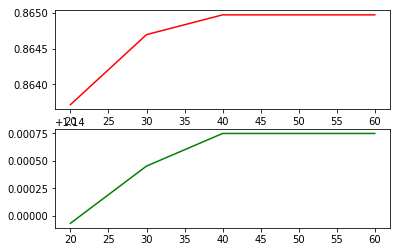

In [371]:
plt.subplot(2, 1, 1) 
plt.plot(plotdata_max_k.k, plotdata_max_k.MAE, 'r')
plt.subplot(2, 1, 2)
plt.plot(plotdata_max_k.k, plotdata_max_k.RMSE, 'g')
plt.show()

In [372]:
plotdata_mink = plotdata[plotdata.sim_matric =='cosine']
plotdata_mink = plotdata_mink[plotdata_mink.min_support == 3]
plotdata_mink = plotdata_mink[plotdata_mink.k == 40]
plotdata_mink

MAE      RMSE   k  min_k sim_matric  min_support
58  0.864973  1.140749  40      1     cosine            3
67  0.815545  1.045538  40      5     cosine            3
76  0.806868  1.042273  40     10     cosine            3

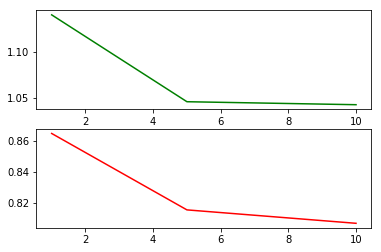

In [373]:
plt.subplot(2, 1, 2) 
plt.plot(plotdata_mink.min_k, plotdata_mink.MAE, 'r')
plt.subplot(2, 1, 1)
plt.plot(plotdata_mink.min_k, plotdata_mink.RMSE, 'g')
plt.show()

In [374]:
plotdata_sim = plotdata[plotdata.min_k ==1]
plotdata_sim = plotdata_sim[plotdata_sim.min_support == 0]
plotdata_sim = plotdata_sim[plotdata_sim.k == 40]
plotdata_sim

MAE      RMSE   k  min_k sim_matric  min_support
54  0.850682  1.128388  40      1        msd            0
57  0.864973  1.140749  40      1     cosine            0
60  0.875957  1.160948  40      1    pearson            0